## ===Task===
Your work: Let's modify the above scratch code to

- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score. Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class KNN(k=3). It should have at least one method, predict(X_train, X_test, y_train)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#let's consider the following 2D data with 4 classes
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Prepare your data

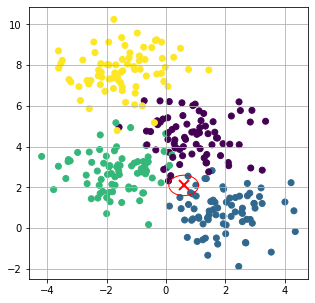

In [29]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#where should this value be classified as?
ax.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
#let's say roughly 5 neighbors
circle = plt.Circle((0.6, 2.1), 0.5, color='red', fill=False)
ax.add_artist(circle)

In [4]:
#1.Prepare the data
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Write a function

In [13]:
class KNN:
    def __init__(self, k=3):
        self.k = k
    
    #2.Function for pairwise distance
    def find_distance(self, X_train, X_test):
        #create newaxis simply so that broadcast to all values
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2
        
        #sum across feature dimension, thus axis = 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist
    
    #3.Argsort the pairwise distance matrix
    def find_neighbors(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:self.k]
        return neighbors_ix
    #if we have k>3
    def find_neighbors_without_k(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)
        return neighbors_ix
    
    #4.Get the majority class
    #From solutions
    def get_most_common(self, y, n_classes, X_train, X_test):
        y_nearest = y[0: self.k]
        bincount = np.bincount(y_nearest, minlength = n_classes) #bincount returns the count of each value
        largest = bincount.argmax() #argmax returns the most common value
        second_largest = bincount.argsort()[-2:][0] #if we want the second most_common, we can use argsort, then do -2
        
        #we take the third most common as the decider, if the first two most common is the same
        if bincount[largest] == bincount[second_largest]:
            y_nearest = y[0: self.k+1] #add one more neighbor
            return np.bincount(y_nearest).argmax(), bincount[largest] / bincount.sum()
        return np.bincount(y_nearest).argmax(), bincount[largest] / bincount.sum()
    
    def predict(self, X_train, X_test, y_train):
        n_classes = len(np.unique(y_train))    
        neighbors_ix = self.find_neighbors(X_train, X_test)
        pred = np.zeros(X_test.shape[0])
        pred_prob = np.zeros(X_test.shape[0])
        for ix, y in enumerate(y_train[neighbors_ix]):
            pred[ix], pred_prob[ix] = self.get_most_common(y, n_classes, X_train, X_test)
        return pred, pred_prob 

    #From solution
    #cv checking
    def cv(self, X_train, y_train, cv, k):
        foldsize = int(X_train.shape[0]/cv)
        yhat_cv = np.zeros((len(k), cv))
        yhat_cv_prob = np.zeros((len(k), cv))
        
        for k_idx, kneighbors in enumerate(k):
            self.k = kneighbors
            for fold_idx, i in enumerate(range(0, X_train.shape[0], foldsize)):
                X_test_ = X_train[i:i+foldsize]
                y_test_ = y_train[i:i+foldsize]
                X_train_ = np.concatenate((X_train[:i], X_train[i+foldsize:]))
                y_train_ = np.concatenate((y_train[:i], y_train[i+foldsize:]))
                yhat, yhat_prob = self.predict(X_train_, X_test_, y_train_)
                accuracy = np.sum(yhat == y_test_)/len(y_test_)
                yhat_cv[k_idx, fold_idx] = accuracy
                yhat_cv_prob[k_idx, fold_idx] = yhat_prob.mean()
        return yhat_cv, yhat_cv_prob

In [16]:
from sklearn.metrics import classification_report
model = KNN()

#From Solution
#check cv
k = np.arange(2, 11)
cv_score, prob_score = model.cv(X_train, y_train, 10, k)
cv_score = cv_score.mean(axis=1)
prob_score = prob_score.mean(axis=1)
for k_idx, kneighbors in enumerate(k):
    print(f"Score with k={kneighbors}: ", cv_score[k_idx], "and prob_score of ", prob_score[k_idx])

#choose model with highest score
model = KNN(k=2)
yhat, yhat_prob = model.predict(X_train, X_test, y_train)

print("=========Accuracy=======")
print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("=========Probability score=======")
print("Probability: ", yhat_prob.mean())

Score with k=2:  0.8952380952380953 and prob_score of  0.930952380952381
Score with k=3:  0.9190476190476191 and prob_score of  0.9301587301587302
Score with k=4:  0.9095238095238096 and prob_score of  0.9285714285714286
Score with k=5:  0.9142857142857144 and prob_score of  0.9295238095238096
Score with k=6:  0.9095238095238096 and prob_score of  0.926984126984127
Score with k=7:  0.9047619047619049 and prob_score of  0.9251700680272108
Score with k=8:  0.9142857142857144 and prob_score of  0.9196428571428571
Score with k=9:  0.9190476190476191 and prob_score of  0.9126984126984128
Score with k=10:  0.9047619047619048 and prob_score of  0.909047619047619
=========Accuracy=======
Accuracy:  0.9666666666666667
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.96      1.00      0.98        25
           2       0.94      0.94      0.94        17
           3     